Our study will be the following: the argentinian ecoomy relies heavily on the exports from their fields. If soy prices go up, dollars enter into the argentinian economy (in theory) and the Central Bank gains in reserves and bonds go up. This phenomena is called "soy-dependance".



In [1]:
# economic information from yahoo finance, already installed it
import yfinance as yf
import pandas_datareader.data as web
import pandas as pd
import datetime

In [7]:
unemployment = web.DataReader('UNRATE', 'fred', datetime.datetime(2000, 1, 1), datetime.datetime(2025, 12, 21))
print(unemployment)

            UNRATE
DATE              
2000-01-01     4.0
2000-02-01     4.1
2000-03-01     4.0
2000-04-01     3.8
2000-05-01     4.0
...            ...
2025-07-01     4.2
2025-08-01     4.3
2025-09-01     4.4
2025-10-01     NaN
2025-11-01     4.6

[311 rows x 1 columns]


In [8]:
# download sp500 from yahoo finance
# data till today
sp500 = yf.download('^GSPC', start='2000-01-01', end='2025-12-21')
sp500.head()

C:\Users\Leonel\AppData\Local\Temp\ipykernel_13712\2224726515.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC', start='2000-01-01', end='2025-12-21')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2000-01-03,1455.219971,1478.000000,1438.359985,1469.250000,931800000
2000-01-04,1399.420044,1455.219971,1397.430054,1455.219971,1009000000
2000-01-05,1402.109985,1413.270020,1377.680054,1399.420044,1085500000
2000-01-06,1403.449951,1411.900024,1392.099976,1402.109985,1092300000
2000-01-07,1441.469971,1441.469971,1400.729980,1403.449951,1225200000


Text(0.5, 1.0, 'Unemployment Rate Over Time')

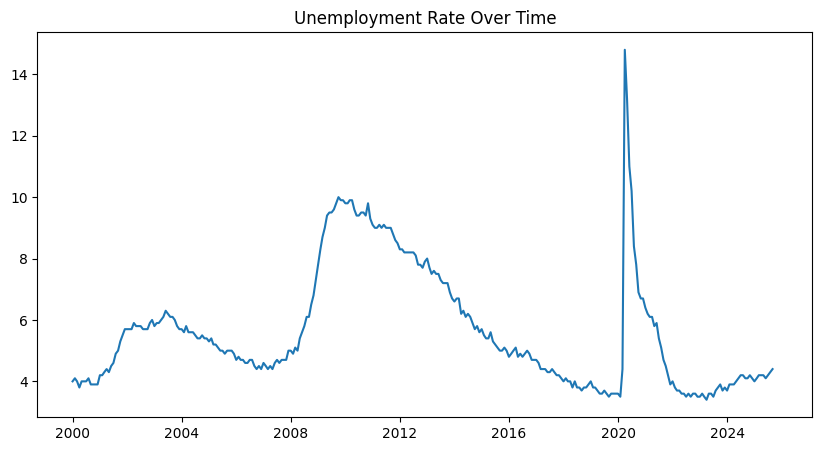

In [10]:
# plot the evoluton of the unemployment rate
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(unemployment.index, unemployment['UNRATE'], label='Unemployment Rate')
plt.title('Unemployment Rate Over Time')

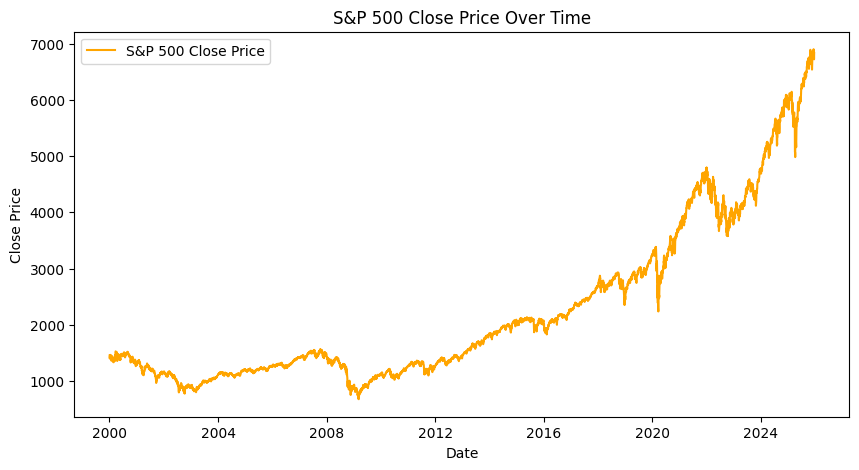

In [11]:
# plot the evolution of the sp500
plt.figure(figsize=(10, 5))
plt.plot(sp500.index, sp500['Close'], label='S&P 500 Close Price', color='orange')
plt.title('S&P 500 Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

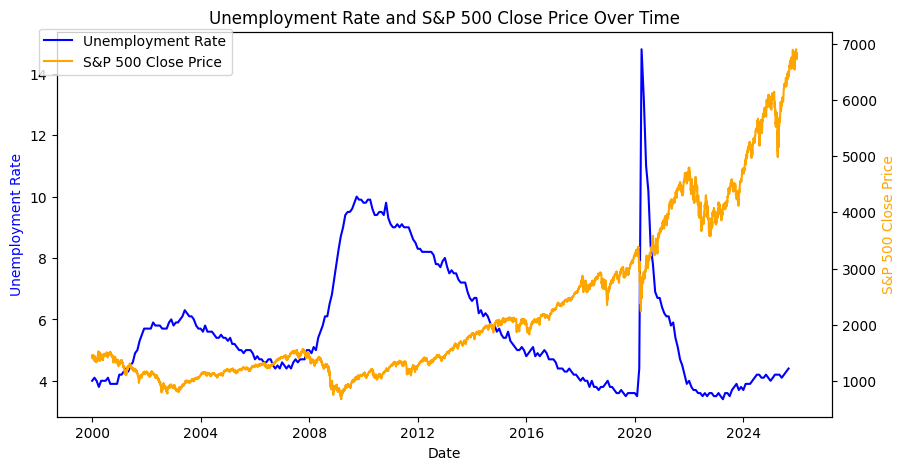

In [12]:
# i want to superimpose both plots in the same graph each with its own y axis
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()
ax1.plot(unemployment.index, unemployment['UNRATE'], label='Unemployment Rate', color
='blue')
ax2.plot(sp500.index, sp500['Close'], label='S&P 500 Close Price', color='orange')
ax1.set_title('Unemployment Rate and S&P 500 Close Price Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Unemployment Rate', color='blue')
ax2.set_ylabel('S&P 500 Close Price', color='orange')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()

In [6]:
import pandas_datareader.data as web
import pandas as pd
import datetime

# 1. Definir el periodo (ej. últimos 20 años)
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2023, 12, 31)

# 2. Diccionario de códigos de FRED (Nombres técnicos -> Nombres legibles)
fred_indicators = {
    'UNRATE': 'Unemployment_Rate',      # TARGET (Mensual)
    'ICSA': 'Initial_Claims',           # Semanal (Muy predictiva)
    'FEDFUNDS': 'Interest_Rate',        # Mensual
    'INDPRO': 'Industrial_Production',  # Mensual
    'UMCSENT': 'Consumer_Sentiment',    # Mensual
    'CPIAUCSL': 'CPI_Inflation',        # Mensual
    'SP500': 'SP500_Index'              # Diario
}

print("Descargando datos de FRED...")
# pandas_datareader puede bajar múltiples series a la vez si le pasas una lista
df = web.DataReader(list(fred_indicators.keys()), 'fred', start, end)

# Renombrar columnas para que se entienda
df = df.rename(columns=fred_indicators)

# --- 3. EL RETO DE FUSIÓN (RESAMPLING) ---
# Tienes datos diarios (SP500), semanales (Claims) y mensuales.
# Objetivo: Convertir todo a MENSUAL para predecir el desempleo de ese mes.

# Reglas de Agrupación:
# - Para SP500: Usamos la media del mes ('mean').
# - Para Claims: Usamos la media del mes.
# - El resto ya son mensuales, tomamos el valor tal cual.
df_monthly = df.resample('MS').mean() 
# 'MS' = Month Start (Alinea todo al día 1 del mes)

# Limpiar nulos (por si alguna serie empieza más tarde)
df_final = df_monthly.dropna()

print(f"Dataset listo: {df_final.shape}")
print(df_final.head())

Descargando datos de FRED...
Dataset listo: (97, 7)
            Unemployment_Rate  Initial_Claims  Interest_Rate  \
DATE                                                           
2015-12-01                5.0        271000.0           0.24   
2016-01-01                4.8        279600.0           0.34   
2016-02-01                4.9        266750.0           0.38   
2016-03-01                5.0        263250.0           0.36   
2016-04-01                5.1        266000.0           0.37   

            Industrial_Production  Consumer_Sentiment  CPI_Inflation  \
DATE                                                                   
2015-12-01                99.0417                92.6        237.761   
2016-01-01                99.5607                92.0        237.652   
2016-02-01                99.0445                91.7        237.336   
2016-03-01                98.3096                91.0        238.080   
2016-04-01                98.6421                89.0        238.99

In [7]:
# Feature Engineering: Crear Lags
# Queremos predecir el desempleo (t) usando datos de (t-1) o (t-3)

# Variable a predecir (Target)
df_final['Target_Next_Month_Unemployment'] = df_final['Unemployment_Rate'].shift(-1)

# Eliminar la última fila (que no tiene "mes siguiente")
df_model = df_final.dropna()

# Ahora tu X (Input) es el dato de "Hoy" y tu Y (Target) es el desempleo del "Mes que viene".
X = df_model.drop('Target_Next_Month_Unemployment', axis=1)
y = df_model['Target_Next_Month_Unemployment']

C:\Users\Leonel\AppData\Local\Temp\ipykernel_18852\1832820036.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Target_Next_Month_Unemployment'] = df_final['Unemployment_Rate'].shift(-1)


--- RESULTADOS ---
Error Medio Absoluto (MAE): 0.11%
Precisión (R2 Score): -0.27 (1.0 es perfecto)


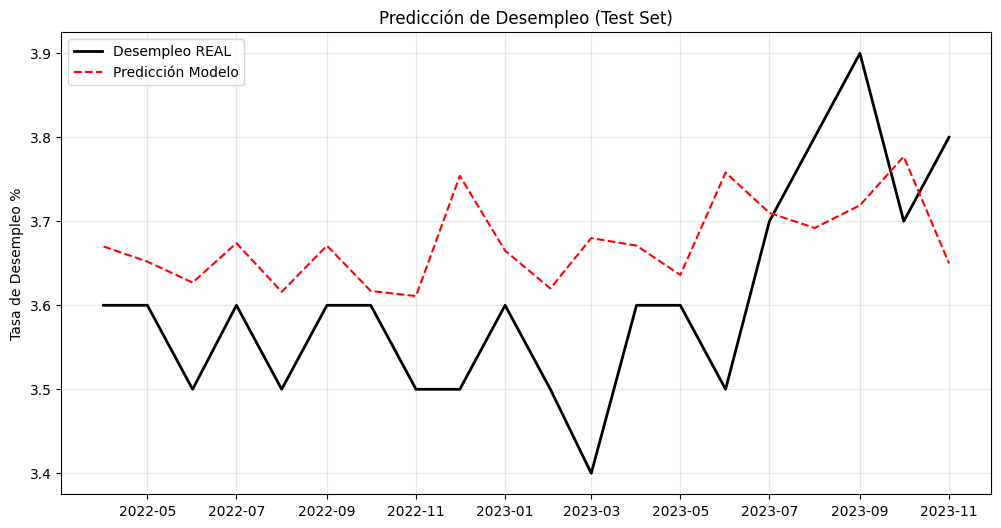

C:\Users\Leonel\AppData\Local\Temp\ipykernel_18852\1139095416.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='viridis')


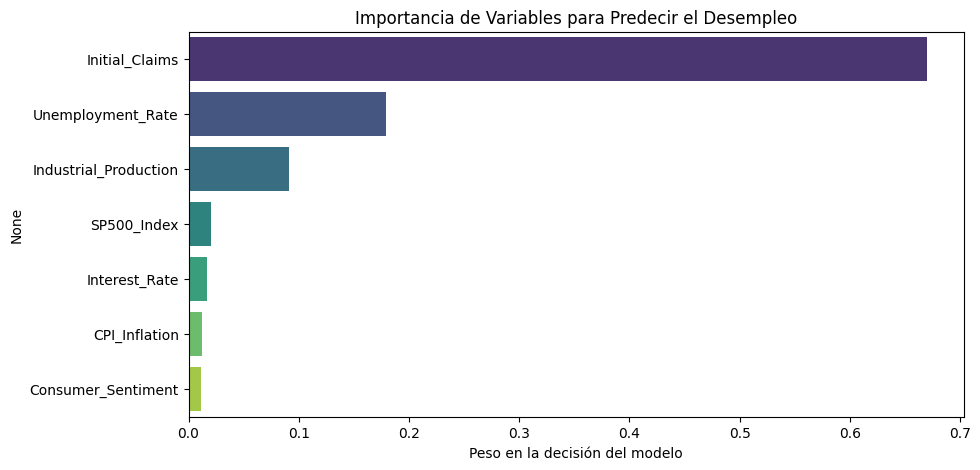

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Split Temporal (Sin mezclar fechas)
# Usaremos el 80% más antiguo para entrenar y el 20% más reciente para probar
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 2. Entrenar el modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 3. Predecir
predictions = model.predict(X_test)

# 4. Evaluar
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"--- RESULTADOS ---")
print(f"Error Medio Absoluto (MAE): {mae:.2f}%")
print(f"Precisión (R2 Score): {r2:.2f} (1.0 es perfecto)")

# --- VISUALIZACIÓN 1: Predicción vs Realidad ---
plt.figure(figsize=(12, 6))
# Creamos un índice de fechas para el gráfico
fechas_test = y_test.index

plt.plot(fechas_test, y_test, label='Desempleo REAL', color='black', linewidth=2)
plt.plot(fechas_test, predictions, label='Predicción Modelo', color='red', linestyle='--')
plt.title('Predicción de Desempleo (Test Set)')
plt.ylabel('Tasa de Desempleo %')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- VISUALIZACIÓN 2: ¿Qué variable importa más? ---
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=importances.values, y=importances.index, palette='viridis')
plt.title('Importancia de Variables para Predecir el Desempleo')
plt.xlabel('Peso en la decisión del modelo')
plt.show()